# Intro to Hidden Markov Models (optional)
---
### Introduction

In this notebook, you'll use the [Pomegranate](http://pomegranate.readthedocs.io/en/latest/index.html) library to build a simple Hidden Markov Model and explore the Pomegranate API.

<div class="alert alert-block alert-info">
**Note:** You are not required to complete this notebook and it will not be submitted with your project, but it is designed to quickly introduce the relevant parts of the Pomegranate library that you will need to complete the part of speech tagger.
</div>

The notebook already contains some code to get you started. You only need to add some new functionality in the areas indicated; you will not need to modify the included code beyond what is requested. Sections that begin with **'IMPLEMENTATION'** in the header indicate that you need to fill in code in the block that follows. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully!

<div class="alert alert-block alert-info">
**Note:** Code and Markdown cells can be executed using the `Shift + Enter` keyboard shortcut. Markdown cells can be edited by double-clicking the cell to enter edit mode.
</div>
<hr>

<div class="alert alert-block alert-warning">
**Note:** Make sure you have selected a **Python 3** kernel in Workspaces or the hmm-tagger conda environment if you are running the Jupyter server on your own machine.
</div>

In [1]:
# Jupyter "magic methods" -- only need to be run once per kernel restart
%load_ext autoreload
%aimport helpers
%autoreload 1

In [2]:
# import python modules -- this cell needs to be run again if you make changes to any of the files
import matplotlib.pyplot as plt
import numpy as np

from helpers import show_model
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

## Build a Simple HMM
---
You will start by building a simple HMM network based on an example from the textbook [Artificial Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/).

> You are the security guard stationed at a secret under-ground installation. Each day, you try to guess whether it’s raining today, but your only access to the outside world occurs each morning when you see the director coming in with, or without, an umbrella.

A simplified diagram of the required network topology is shown below.

![](_example.png)

### Describing the Network

<div class="alert alert-block alert-warning">
$\lambda = (A, B)$ specifies a Hidden Markov Model in terms of an emission probability distribution $A$ and a state transition probability distribution $B$.
</div>

HMM networks are parameterized by two distributions: the emission probabilties giving the conditional probability of observing evidence values for each hidden state, and the transition probabilities giving the conditional probability of moving between states during the sequence. Additionally, you can specify an initial distribution describing the probability of a sequence starting in each state.

<div class="alert alert-block alert-warning">
At each time $t$, $X_t$ represents the hidden state, and $Y_t$ represents an observation at that time.
</div>

In this problem, $t$ corresponds to each day of the week and the hidden state represent the weather outside (whether it is Rainy or Sunny) and observations record whether the security guard sees the director carrying an umbrella or not.

For example, during some particular week the guard may observe an umbrella ['yes', 'no', 'yes', 'no', 'yes'] on Monday-Friday, while the weather outside is ['Rainy', 'Sunny', 'Sunny', 'Sunny', 'Rainy']. In that case, $t=Wednesday$, $Y_{Wednesday}=yes$, and $X_{Wednesday}=Sunny$. (It might be surprising that the guard would observe an umbrella on a sunny day, but it is possible under this type of model.)

### Initializing an HMM Network with Pomegranate
The Pomegranate library supports [two initialization methods](http://pomegranate.readthedocs.io/en/latest/HiddenMarkovModel.html#initialization). You can either explicitly provide the three distributions, or you can build the network line-by-line. We'll use the line-by-line method for the example network, but you're free to use either method for the part of speech tagger.

In [3]:
# create the HMM model
model = HiddenMarkovModel(name="Example Model")

### **IMPLEMENTATION**: Add the Hidden States
When the HMM model is specified line-by-line, the object starts as an empty container. The first step is to name each state and attach an emission distribution.

#### Observation Emission Probabilities: $P(Y_t | X_t)$
We need to assume that we have some prior knowledge (possibly from a data set) about the director's behavior to estimate the emission probabilities for each hidden state. In real problems you can often estimate the emission probabilities empirically, which is what we'll do for the part of speech tagger. Our imaginary data will produce the conditional probability table below. (Note that the rows sum to 1.0)

| |  $yes$  | $no$ |
| --- | --- | --- |
| $Sunny$ |   0.10  | 0.90 |
| $Rainy$ | 0.80 | 0.20 |

In [4]:
# create the HMM model
model = HiddenMarkovModel(name="Example Model")

# emission probability distributions, P(umbrella | weather)
sunny_emissions = DiscreteDistribution({"yes": 0.1, "no": 0.9})
sunny_state = State(sunny_emissions, name="Sunny")

# TODO: create a discrete distribution for the rainy emissions from the probability table
# above & use that distribution to create a state named Rainy
rainy_emissions = DiscreteDistribution({"yes": 0.8, "no": 0.2})
rainy_state = State(rainy_emissions, name="Rainy")

# add the states to the model
model.add_states(sunny_state, rainy_state)

assert rainy_emissions.probability("yes") == 0.8, "The director brings his umbrella with probability 0.8 on rainy days"
print("Looks good so far!")

Looks good so far!


### **IMPLEMENTATION:** Adding Transitions
Once the states are added to the model, we can build up the desired topology of individual state transitions.

#### Initial Probability $P(X_0)$:
We will assume that we don't know anything useful about the likelihood of a sequence starting in either state. If the sequences start each week on Monday and end each week on Friday (so each week is a new sequence), then this assumption means that it's equally likely that the weather on a Monday may be Rainy or Sunny. We can assign equal probability to each starting state by setting $P(X_0=Rainy) = 0.5$ and $P(X_0=Sunny)=0.5$:

| $Sunny$ | $Rainy$ |
| --- | ---
| 0.5 | 0.5 |

#### State transition probabilities $P(X_{t} | X_{t-1})$
Finally, we will assume for this example that we can estimate transition probabilities from something like historical weather data for the area. In real problems you can often use the structure of the problem (like a language grammar) to impose restrictions on the transition probabilities, then re-estimate the parameters with the same training data used to estimate the emission probabilities. Under this assumption, we get the conditional probability table below. (Note that the rows sum to 1.0)

| | $Sunny$ | $Rainy$ |
| --- | --- | --- |
|$Sunny$| 0.80 | 0.20 |
|$Rainy$| 0.40 | 0.60 |

In [5]:
# create edges for each possible state transition in the model
# equal probability of a sequence starting on either a rainy or sunny day
model.add_transition(model.start, sunny_state, 0.5)
model.add_transition(model.start, rainy_state, 0.5)

# add sunny day transitions (we already know estimates of these probabilities
# from the problem statement)
model.add_transition(sunny_state, sunny_state, 0.8)  # 80% sunny->sunny
model.add_transition(sunny_state, rainy_state, 0.2)  # 20% sunny->rainy

# TODO: add rainy day transitions using the probabilities specified in the transition table
model.add_transition(rainy_state, sunny_state, 0.4)  # 40% rainy->sunny
model.add_transition(rainy_state, rainy_state, 0.6)  # 60% rainy->rainy

# finally, call the .bake() method to finalize the model
model.bake()

assert model.edge_count() == 6, "There should be two edges from model.start, two from Rainy, and two from Sunny"
assert model.node_count() == 4, "The states should include model.start, model.end, Rainy, and Sunny"
print("Great! You've finished the model.")

Great! You've finished the model.


## Visualize the Network
---
We have provided a helper function called `show_model()` that generates a PNG image from a Pomegranate HMM network. You can specify an optional filename to save the file to disk. Setting the "show_ends" argument True will add the model start & end states that are included in every Pomegranate network.

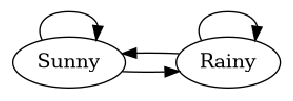

In [6]:
show_model(model, figsize=(5, 5), filename="example.png", overwrite=True, show_ends=False)

### Checking the Model
The states of the model can be accessed using array syntax on the `HMM.states` attribute, and the transition matrix can be accessed by calling `HMM.dense_transition_matrix()`. Element $(i, j)$ encodes the probability of transitioning from state $i$ to state $j$. For example, with the default column order specified, element $(2, 1)$ gives the probability of transitioning from "Rainy" to "Sunny", which we specified as 0.4.

Run the next cell to inspect the full state transition matrix, then read the . 

In [7]:
column_order = ["Example Model-start", "Sunny", "Rainy", "Example Model-end"]  # Override the Pomegranate default order
column_names = [s.name for s in model.states]
order_index = [column_names.index(c) for c in column_order]

# re-order the rows/columns to match the specified column order
transitions = model.dense_transition_matrix()[:, order_index][order_index, :]
print("The state transition matrix, P(Xt|Xt-1):\n")
print(transitions)
print("\nThe transition probability from Rainy to Sunny is {:.0f}%".format(100 * transitions[2, 1]))

The state transition matrix, P(Xt|Xt-1):

[[0.  0.5 0.5 0. ]
 [0.  0.8 0.2 0. ]
 [0.  0.4 0.6 0. ]
 [0.  0.  0.  0. ]]

The transition probability from Rainy to Sunny is 40%


In [8]:
model.dense_transition_matrix()

array([[0.6, 0.4, 0. , 0. ],
       [0.2, 0.8, 0. , 0. ],
       [0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. ]])

## Inference in Hidden Markov Models
---
Before moving on, we'll use this simple network to quickly go over the Pomegranate API to perform the three most common HMM tasks:

<div class="alert alert-block alert-info">
**Likelihood Evaluation**<br>
Given a model $\lambda=(A,B)$ and a set of observations $Y$, determine $P(Y|\lambda)$, the likelihood of observing that sequence from the model
</div>

We can use the weather prediction model to evaluate the likelihood of the sequence [yes, yes, yes, yes, yes] (or any other state sequence). The likelihood is often used in problems like machine translation to weight interpretations in conjunction with a statistical language model.

<div class="alert alert-block alert-info">
**Hidden State Decoding**<br>
Given a model $\lambda=(A,B)$ and a set of observations $Y$, determine $Q$, the most likely sequence of hidden states in the model to produce the observations
</div>

We can use the weather prediction model to determine the most likely sequence of Rainy/Sunny states for a known observation sequence, like [yes, no] -> [Rainy, Sunny]. We will use decoding in the part of speech tagger to determine the tag for each word of a sentence. The decoding can be further split into "smoothing" when we want to calculate past states, "filtering" when we want to calculate the current state, or "prediction" if we want to calculate future states. 

<div class="alert alert-block alert-info">
**Parameter Learning**<br>
Given a model topography (set of states and connections) and a set of observations $Y$, learn the transition probabilities $A$ and emission probabilities $B$ of the model, $\lambda=(A,B)$
</div>

We don't need to learn the model parameters for the weather problem or POS tagging, but it is supported by Pomegranate.

### IMPLEMENTATION: Calculate Sequence Likelihood

Calculating the likelihood of an observation sequence from an HMM network is performed with the [forward algorithm](https://en.wikipedia.org/wiki/Forward_algorithm). Pomegranate provides the the `HMM.forward()` method to calculate the full matrix showing the likelihood of aligning each observation to each state in the HMM, and the `HMM.log_probability()` method to calculate the cumulative likelihood over all possible hidden state paths that the specified model generated the observation sequence.

Fill in the code in the next section with a sample observation sequence and then use the `forward()` and `log_probability()` methods to evaluate the sequence.

In [9]:
# TODO: input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

assert len(observations) > 0, "You need to choose a sequence of 'yes'/'no' observations to test"

# TODO: use model.forward() to calculate the forward matrix of the observed sequence,
# and then use np.exp() to convert from log-likelihood to likelihood
forward_matrix = np.exp(model.forward(observations))

# TODO: use model.log_probability() to calculate the all-paths likelihood of the
# observed sequence and then use np.exp() to convert log-likelihood to likelihood
probability_percentage = np.exp(model.log_probability(observations))

# Display the forward probabilities
print("         " + "".join(s.name.center(len(s.name)+6) for s in model.states))
for i in range(len(observations) + 1):
    print(" <start> " if i==0 else observations[i - 1].center(9), end="")
    print("".join("{:.0f}%".format(100 * forward_matrix[i, j]).center(len(s.name) + 6)
                  for j, s in enumerate(model.states)))

print("\nThe likelihood over all possible paths " + \
      "of this model producing the sequence {} is {:.2f}%\n\n"
      .format(observations, 100 * probability_percentage))

            Rainy      Sunny      Example Model-start      Example Model-end   
 <start>      0%         0%               100%                     0%          
   yes       40%         5%                0%                      0%          
    no        5%        18%                0%                      0%          
   yes        5%         2%                0%                      0%          

The likelihood over all possible paths of this model producing the sequence ['yes', 'no', 'yes'] is 6.92%




### IMPLEMENTATION: Decoding the Most Likely Hidden State Sequence

The [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm) calculates the single path with the highest likelihood to produce a specific observation sequence. Pomegranate provides the `HMM.viterbi()` method to calculate both the hidden state sequence and the corresponding likelihood of the viterbi path.

This is called "decoding" because we use the observation sequence to decode the corresponding hidden state sequence. In the part of speech tagging problem, the hidden states map to parts of speech and the observations map to sentences. Given a sentence, Viterbi decoding finds the most likely sequence of part of speech tags corresponding to the sentence.

Fill in the code in the next section with the same sample observation sequence you used above, and then use the `model.viterbi()` method to calculate the likelihood and most likely state sequence. Compare the Viterbi likelihood against the forward algorithm likelihood for the observation sequence.

In [10]:
# TODO: input a sequence of 'yes'/'no' values in the list below for testing
observations = ['yes', 'no', 'yes']

# TODO: use model.viterbi to find the sequence likelihood & the most likely path
viterbi_likelihood, viterbi_path = model.viterbi(observations)

print("The most likely weather sequence to have generated " + \
      "these observations is {} at {:.2f}%."
      .format([s[1].name for s in viterbi_path[1:]], np.exp(viterbi_likelihood)*100)
)

The most likely weather sequence to have generated these observations is ['Rainy', 'Sunny', 'Rainy'] at 2.30%.


### Forward likelihood vs Viterbi likelihood
Run the cells below to see the likelihood of each sequence of observations with length 3, and compare with the viterbi path.

In [11]:
from itertools import product

observations = ['no', 'no', 'yes']

p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is...".format(o))
for s in product(*[['Sunny', 'Rainy']]*3):
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

The likelihood of observing ['no', 'no', 'yes'] if the weather sequence is...
	('Sunny', 'Sunny', 'Sunny') is 2.59% 
	('Sunny', 'Sunny', 'Rainy') is 5.18%  <-- Viterbi path
	('Sunny', 'Rainy', 'Sunny') is 0.07% 
	('Sunny', 'Rainy', 'Rainy') is 0.86% 
	('Rainy', 'Sunny', 'Sunny') is 0.29% 
	('Rainy', 'Sunny', 'Rainy') is 0.58% 
	('Rainy', 'Rainy', 'Sunny') is 0.05% 
	('Rainy', 'Rainy', 'Rainy') is 0.58% 

The total likelihood of observing ['no', 'no', 'yes'] over all possible paths is 10.20%


### Congratulations!
You've now finished the HMM warmup. You should have all the tools you need to complete the part of speech tagger project.